# Visualization of 4D Geometry using PCA

This notebook demonstrates how to construct a 4-dimensional line by integrating the Frenet Formulas, and visualize it with orthogonal projection. Information on how the 4D Frenet formula is derived can be found in the paper in this repo: https://github.com/panangam/4d-helix

The example used here is a 4D helix, an analog to the 3D helix with all the curvatures equal to 1. 

### Frenet Formulas?

<img src="https://upload.wikimedia.org/wikipedia/commons/1/11/Frenet.svg" style="height: 300px; width: auto">

"Frenet-Serret Formulas," or sometimes Frenet formulas for short, are the ODEs describing the trajectory of a space curve in terms of tangent, normal, and binormal vectors (T, N, and B). This gives us a way to define a space curve by its curvatures. For example, when you set the curvature ($\kappa$) and torsion ($\tau$) to constant values, you get a helix. 

<img src="https://upload.wikimedia.org/wikipedia/commons/8/87/Frenetframehelix.gif">

Here, I generalized the Frenet formulas to work in a 4-dimensional case, which introduces another directional vector (Q) and another curvature ($\xi$).

https://en.wikipedia.org/wiki/Frenet%E2%80%93Serret_formulas

### 4D Frenet Formulas

<img src="4d_frenet.png" style="height: 100px">

### Symbols

- `T, N, B, Q`: the tangent, normal, binormal, and the 4th principal direction vectors from the Frenet formulas.
- `kappa, tau, xi`: the three curvatures ($\kappa, \tau, \xi$) from the Frenet formulas 
- `alpha`: the position of the line parametrized by arclength

In [78]:
import numpy as np
from scipy.integrate import solve_ivp, odeint
import vedo
import k3d
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from ipywidgets import interactive, FloatSlider, TwoByTwoLayout
from IPython.display import display, HTML

%config InlineBackend.figure_format = 'retina'
default_camera = [0, 0.1, 4, 0, 0, 0, 0, 1, 0]

## 1) Integrate the ODEs to get the positions

In [4]:
# set up initial conditions
alpha0 = (0, -1, 0, -1)
T0 = (1, 0, 0, 0)
N0 = (0, 1, 0, 0)
B0 = (0, 0, 1, 0)
Q0 = (0, 0, 0, 1)
y0 = np.stack((alpha0, T0, N0, B0, Q0)).flatten()

kappa = 1
tau = 1
xi = 1

# define frenet formula 
frenet_mat = np.array([
    [0, kappa, 0, 0],
    [-kappa, 0, tau, 0],
    [0, -tau, 0, xi],
    [0, 0, -xi, 0]
])
velocity_mat = np.array([1, 1, 1, 1])

def ode_rhs(t, y):
    # reshape variables into alpha, T, N, B, Q
    vecs = np.reshape(y, (5, 4))
    # calculate gradient for T, N, B, Q
    frenet_rhs = frenet_mat @ vecs[1:]
    # calculate gradient for alpha (velocity * T)
    alpha_rhs = velocity_mat * vecs[[1]]
    # concatenate flatten into a vector again
    return np.concatenate((alpha_rhs, frenet_rhs), axis=0).flatten()

In [5]:
# solve ODE using scipy's solver
min_s, max_s, steps = 0, 500, 2000
ts = np.linspace(min_s, max_s, steps)
res = solve_ivp(ode_rhs, (min_s, max_s), y0, t_eval=ts)
ys = res['y']
alpha = ys[:4].T

## 2) Visualize

First, let's try plotting out the values of each coordinate over time.

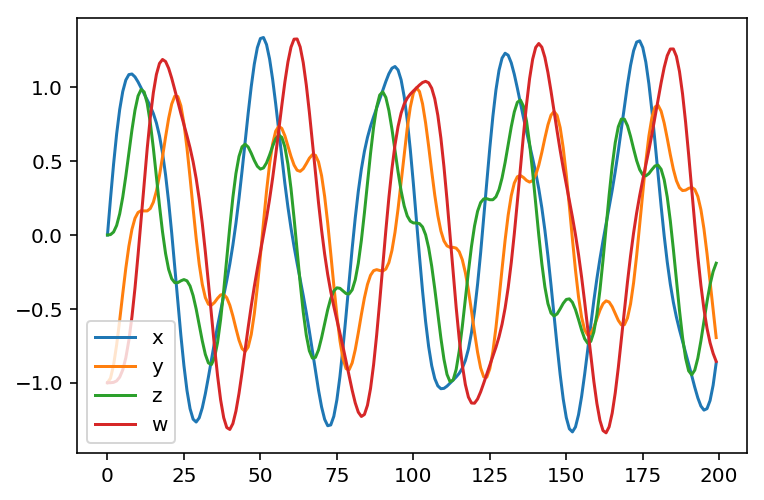

In [77]:
plt.plot(alpha[:200])
plt.legend('xyzw')
plt.show()

Unlike the 3D helix which spirals out to infinity, the 4D helix analog is actually bounded! 

We can also do orthogonal projection using 3 coordinates at a time. This is equivalent to casting shadows onto a lower dimension.

<img src="https://upload.wikimedia.org/wikipedia/commons/4/48/Axonometric_projection.svg" style="height: 200px">

A 3D object casts a 2D shadow. Likewise, a 4D object casts a 3D shadow, which we can see.

In [27]:
proj_names = ['xyz', 'xyw', 'xzw', 'yzw']
proj_vecs = [np.delete(np.arange(4), i) for i in range(4)]

In [79]:
lines = [vedo.Line(alpha[:, proj_vecs[i]], c='b')+vedo.Text(proj_names[i], (0, 1, 0), 0.5) for i in range(4)]
plots = [vedo.show(l) for l in lines]
for p in plots: p.camera = default_camera
TwoByTwoLayout(top_left=plots[0], top_right=plots[1], bottom_left=plots[2], bottom_right=plots[3])

TwoByTwoLayout(children=(Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, c…

This gives us another view of the bounded nature of the 4D helix.

## 3) PCA treatment

PCA (principal component analysis) projects a set of points into the directions with the maximum variance. In effect, it can be used to find a "natural" projecting direction of a shape in higher dimensions. 

Since PCA components are orthonormal, projecting into the PCA space is also equivalent to a rotation in 4D, thus it does not affect the shape in question.

In [36]:
pca = PCA(n_components=4)
alpha_pca = pca.fit_transform(alpha)

## 4) Visualize the PCA-treated curve

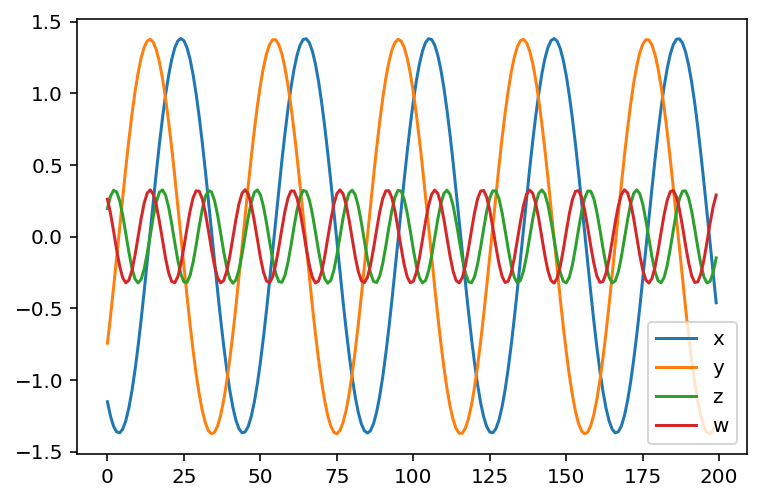

In [81]:
plt.plot(alpha_pca[:200])
plt.legend('xyzw')
plt.show()

The PCA projection reveals that the curves are just pairs of sines and cosines! This shows us that the 4D helix in fact lies on a "flat torus", a 2-manifold in 4D with torus topology. The formula of such a surface is

$$x(u, v) = (a \cos u, a \sin u, b \cos v, b \sin v)$$

Orthogonal projections show that the pairs of waves with the same amplitude are indeed sine and cosine pairs, forming circle when viewed from a correct angle.

In [80]:
lines_pca = [vedo.Line(alpha_pca[:, proj_vecs[i]], c='b')+vedo.Text(proj_names[i], (0, 1, 0), 0.5) for i in range(4)]
plots_pca = [vedo.show(l, camera=default_camera) for l in lines_pca]
for p in plots_pca: p.camera = default_camera
TwoByTwoLayout(top_left=plots_pca[0], top_right=plots_pca[1], bottom_left=plots_pca[2], bottom_right=plots_pca[3])

TwoByTwoLayout(children=(Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, c…

## Conclusion

Using PCA shows us visually that the 4D helix lies on very nice surface, a flat torus, even though the initial integrated solution looks chaotic. To me, this is an unexpected application of a very common data analysis technique.